# Problem 3

## (a),(b)

In [1]:
# generation of quasi-orthogonal basis vectors (u) as a 100x6 matrix
%matplotlib notebook
import numpy as np
import hickle as hkl
d = 100

def draw_vector(bseed):
    rng = np.random.default_rng(bseed)
    r = rng.multinomial(1,[2/3, 1/6, 1/6],size=d)
    
    def map_vector(r_1):
        if r_1[0]:
            return 0
        elif r_1[1]:
            return 1
        elif r_1[2]:
            return -1
    
    u_vec = [map_vector(r_1) for r_1 in r]
    return u_vec


u_mat = np.zeros((6,100))
u_mat[0] = draw_vector(5)
u_mat[1] = draw_vector(3)
u_mat[2] = draw_vector(13)
u_mat[3] = draw_vector(1)
u_mat[4] = draw_vector(17)
u_mat[5] = draw_vector(10)
#u_mat = u_mat.T    # uncomment for u generation

u_mat = hkl.load('u_mat_rev.hkl')

for i in range(6):
    for j in range(6):
        u_1 = u_mat[:,i].reshape(1,100);
        u_2 = u_mat[:,j].reshape(1,100);
        inner_pr = np.inner(u_1,u_2)
        #if i!=j:
            #print('[', i+1, ',',j+1,']:',inner_pr)
    #print('\n')
    

#hkl.dump(u_mat,'u_mat_rev.hkl')



In [2]:
# Generation of Phi matrix mxd
import math
m = 34 # varied, here k can be taken 3 and d=100, 3 log(100) approx 30 (saved for m=10/34/80)
rng = np.random.default_rng()
Phi = rng.integers(2,size=(m,d))
for arr in Phi:
    for i in range(len(arr)):
        if arr[i]==0:
            arr[i]=-1
            

#hkl.dump(Phi,'./p2_Phi_'+str(m) + '.hkl')
Phi = hkl.load('./p2_Phi_'+str(m)+'.hkl')
# For checking uniformity of Phi
print(np.sum(Phi))

-2


In [3]:
# Generation of x = xs (sparse signal) + noise  as a dxN matrix 
d = 100
u_mat = hkl.load('u_mat_rev.hkl')
def gen_from_comp(u_mat, choice):
    res = np.zeros((d,1))
    v1 = np.random.randn()
    v2 = np.random.randn()
    
    
    if choice[0]:
        res = 2*u_mat[:,0] + 0.5*v1*u_mat[:,1] + v2*u_mat[:,2]
    elif choice[1]:
        res = 1.5*u_mat[:,3] + v1*u_mat[:,4] + 0.8*v2*u_mat[:,5]
    elif choice[2]:
        res = u_mat[:,5] + v1*(u_mat[:,0]-u_mat[:,1]) + 0.7*v2*u_mat[:,4]
    return res # = xs


n = 1  # varied
noisy_signal = np.zeros((d,n))  #x
sparse_signal = np.zeros((d,n)) #xs
one_hot_labels = np.zeros((3,n))  #z

for i in range(n):
    x = np.zeros((d,1))  # x = xs + N
    xs = np.zeros((d,1))
    N = np.zeros((d,1))
    # Generation of noise vector
    sigma = 0.01
    cov = sigma**2 * np.ones((d,d))
    N_mat = np.random.normal(0, cov)
    n_draw = np.random.randint(0,d) #index of noise vector to draw
    N = N_mat[:,n_draw]
    
    
    label = np.zeros((3,1))
    rng = np.random.default_rng()
    comp_draw = rng.multinomial(1,[1/3, 1/3, 1/3],size=1)[0]  # one hot encoded array of length 3 indicating current component 
    
    #comp_draw = np.random.uniform(0,1)
    xs = gen_from_comp(u_mat,comp_draw)
    
    x = xs + N
    
    noisy_signal[:,i] = x.reshape(d)
    sparse_signal[:,i] = xs.reshape(d)
    one_hot_labels[:,i] = comp_draw.reshape(3)

info = { 'noisy_x': noisy_signal, 'sparse_x': sparse_signal, 'label':one_hot_labels}
filenameP= 'p2_data_'
filenameS = '_dim_' + str(d) + '.hkl'
#hkl.dump(info ,filenameP + str(n) + filenameS)  #uncomment to save new data
info = hkl.load(filenameP + str(n) + filenameS)
x = info['noisy_x']
xs = info['sparse_x']
z = info['label']

In [8]:
# Computation of compressive projection
import math
p = 1/math.sqrt(m) * (Phi@x)

# Basis for the signal B = [u1 u2 u3 u4 u5 u6]  dx6
B = u_mat

# Problem 4

In [9]:
from sklearn import linear_model

p1 = Phi @ x #scikit-learn uses p without 1/sqrt(m) factor
Phi_cap = Phi @ B
lambda_1 = 0.1   #hyperparameter
clf = linear_model.Lasso(alpha=lambda_1)
clf.fit(Phi_cap,p1)

# s matrix (6x1)
clf.coef_

array([ 1.99554327, -0.52848404,  0.22630748,  0.        , -0.        ,
       -0.        ])

In [13]:
# Calculation of reconstruction accuracy
s = clf.coef_.reshape(6,1)
xs_cap = B @ s
loss_norm = np.linalg.norm(xs_cap-xs)
sparse_signal_norm = np.linalg.norm(xs)
norm_MSE = (loss_norm**2)/(sparse_signal_norm**2)
print('||xs_cap - xs||_2 =',loss_norm)
print('Norm MSE = ',norm_MSE)
print('Total energy of xs = ', sparse_signal_norm)
print('Reconstruction Accuracy %: ', (1 - (loss_norm/sparse_signal_norm))*100)


||xs_cap - xs||_2 = 0.03796759195740634
Norm MSE =  8.814349205731208e-06
Total energy of xs =  12.78845051495792
Reconstruction Accuracy %:  99.70311030321463


# Problem 5

In [14]:
# Normalized MSE averaged over many draws

from sklearn import linear_model
num_draws = 100 # number of draws
total_data_num = 1000
filenameP= 'p2_data_'
filenameS = '_dim_' + str(d) + '.hkl'
info = hkl.load(filenameP + str(total_data_num) + filenameS)

# Loading values into matrices
x_mat = info['noisy_x']
xs_mat = info['sparse_x']
z_mat = info['label']

# Basis for the signal B = [u1 u2 u3 u4 u5 u6]  dx6
B = u_mat
Phi_cap = Phi @ B
norm_MSE = 0
for i in range(num_draws):
    x = x_mat[:,i].reshape(100,1)
    xs = xs_mat[:,i].reshape(100,1)
    z = z_mat[:,i].reshape(3,1)
    
    # Computation of compressive projection
    p = 1/math.sqrt(m) * (Phi@x)
    p1 = Phi @ x #scikit-learn uses p without 1/sqrt(m) factor
    lambda_1 = 0.1
    clf = linear_model.Lasso(alpha=lambda_1)
    clf.fit(Phi_cap,p1)
    
    
    s = clf.coef_.reshape(6,1)
    xs_cap = B @ s
    loss_norm = np.linalg.norm(xs_cap-xs)
    sparse_signal_norm = np.linalg.norm(xs)
    norm_MSE = norm_MSE + (loss_norm**2)/(sparse_signal_norm**2)
    #print('||xs_cap - xs||_2 =',loss_norm)
    #print('Total energy of xs = ', sparse_signal_norm)
    #print('Accuracy %: ', (1 - (loss_norm/sparse_signal_norm))*100)
    
print('Normalized MSE averaged over',num_draws,'draws:',norm_MSE/num_draws)

Normalized MSE averaged over 100 draws: 1.927566629946507e-05


<IPython.core.display.Javascript object>


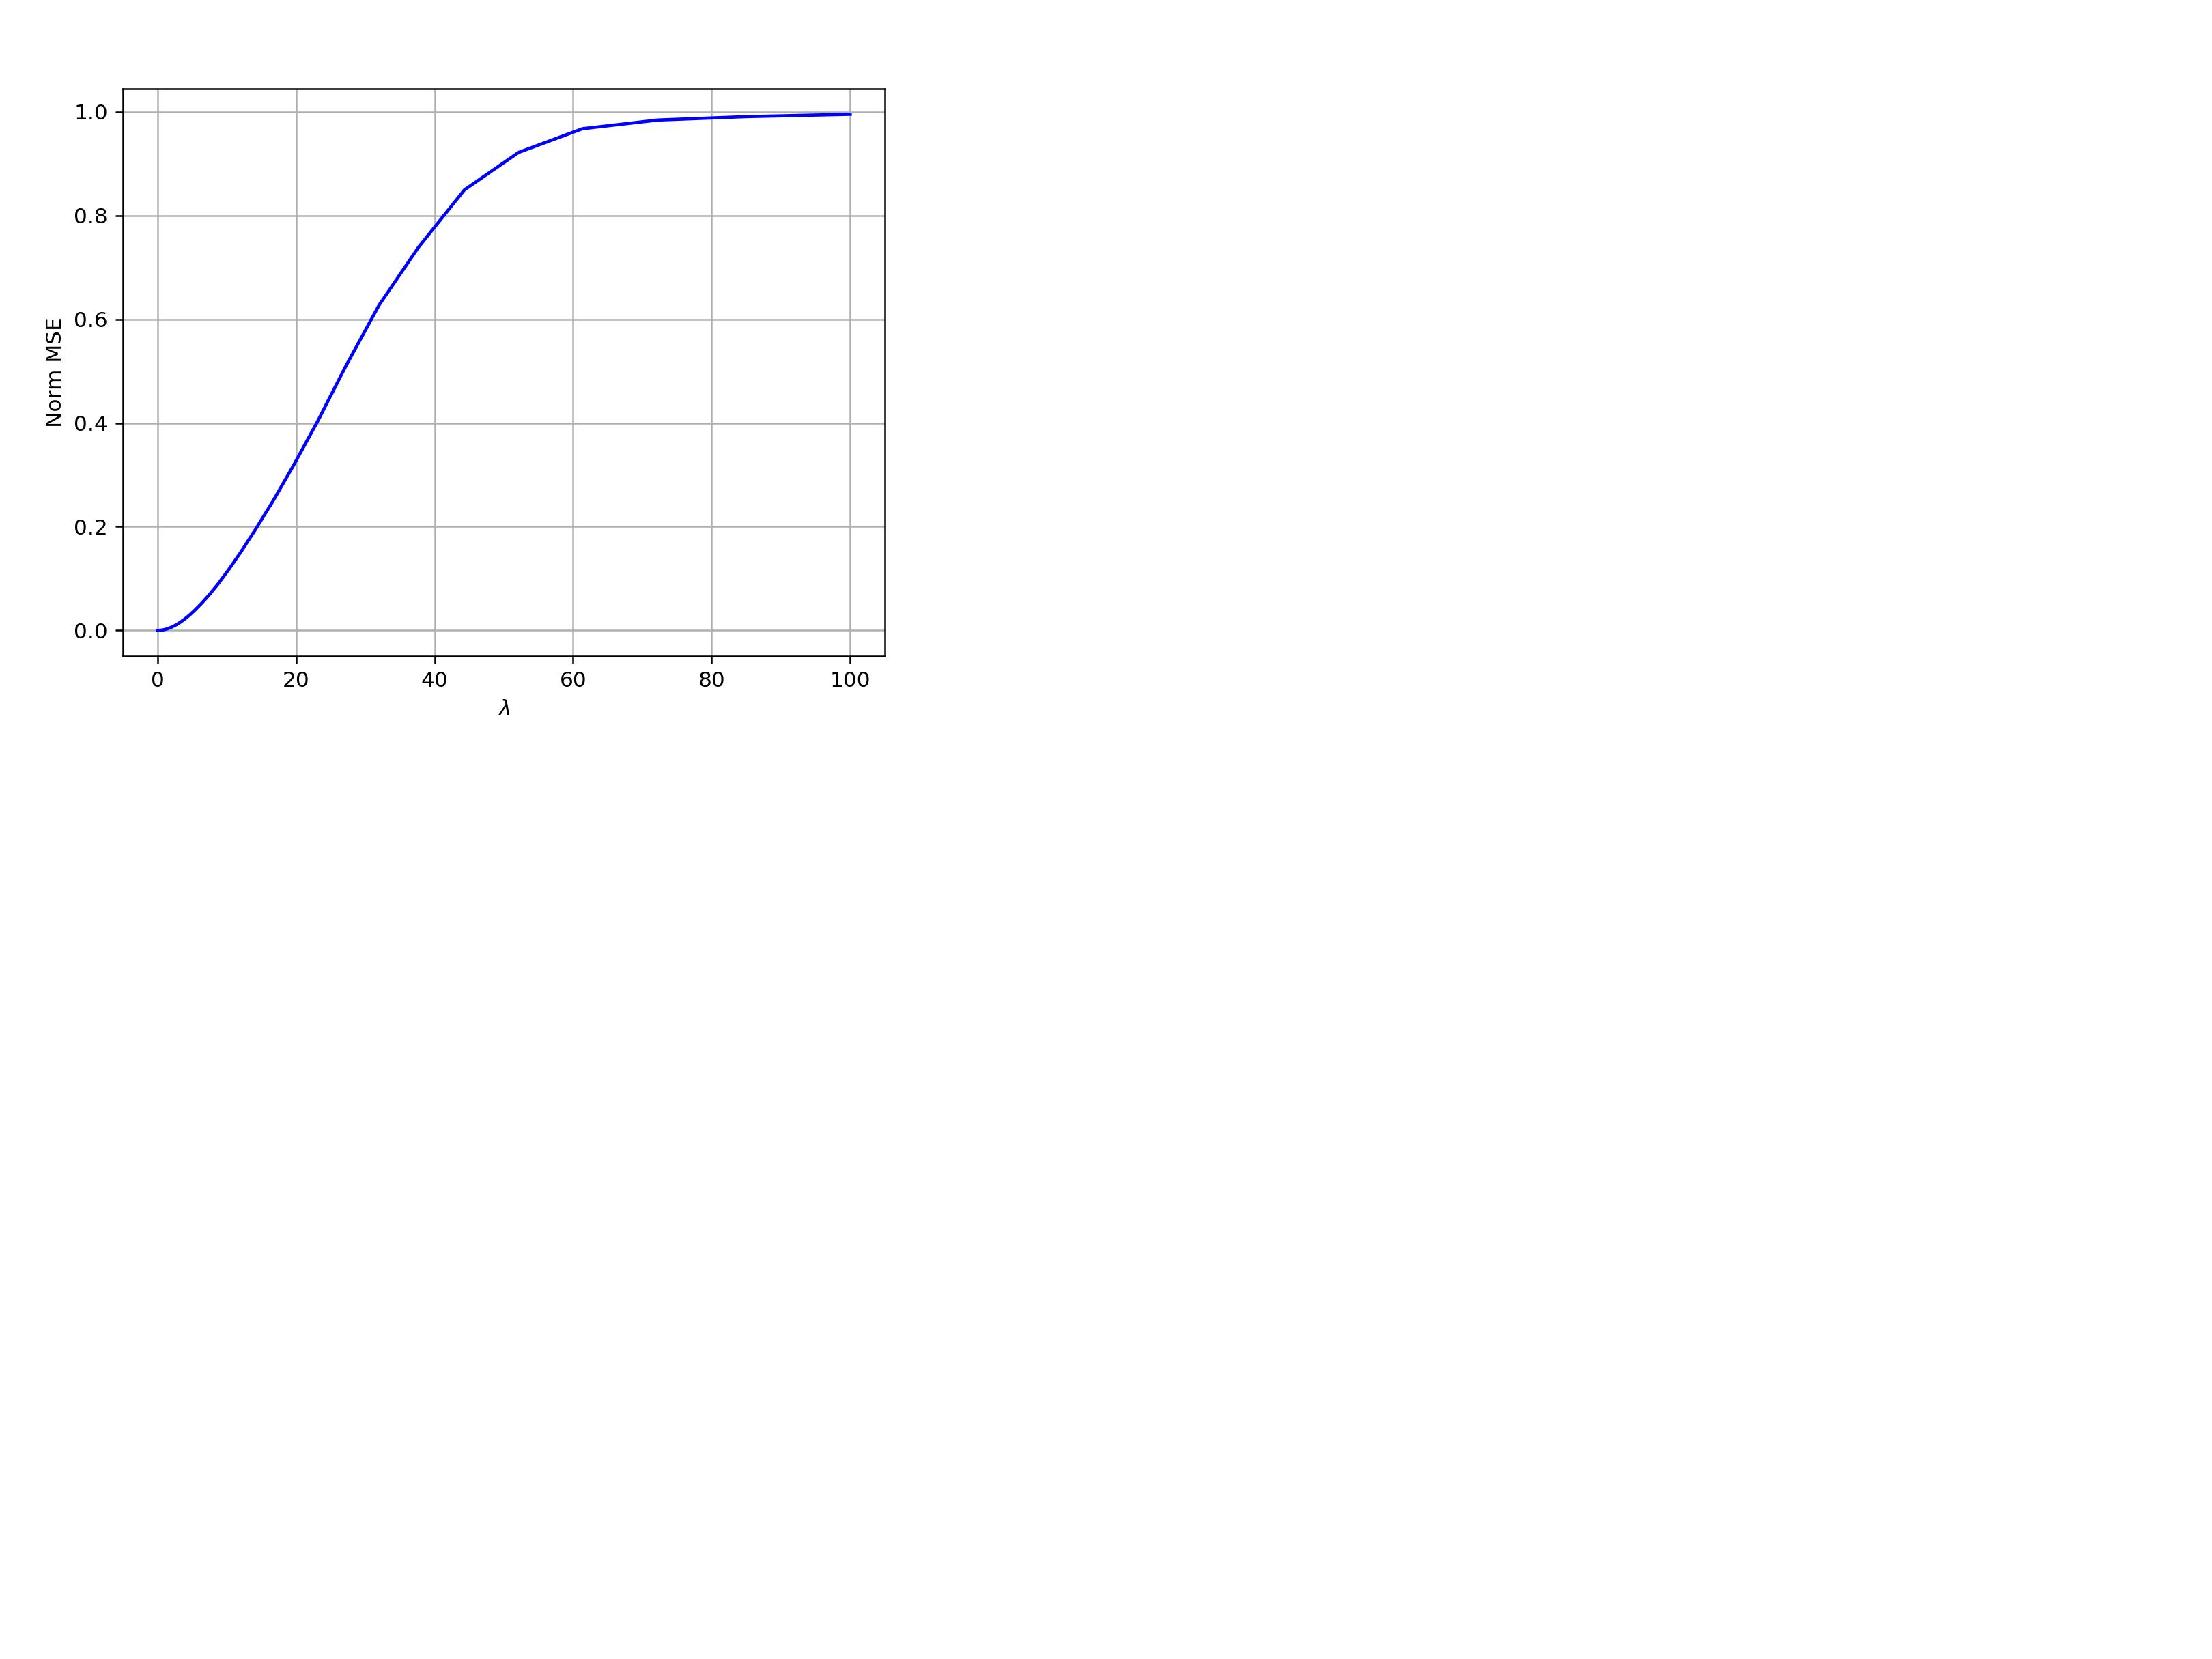

In [15]:
# Plot of normalized MSE versus lambda averaged over all data.

import matplotlib.pyplot as plt
num_draws = 1000
B = u_mat # Basis for the signal B = [u1 u2 u3 u4 u5 u6]  dx6
Phi_cap = Phi @ B
#lambda_arr = np.array([0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,5])
lambda_arr = np.logspace(-5,2,num=100)
norm_MSE_mat = np.zeros(lambda_arr.size)
for j in range(len(lambda_arr)):
    norm_MSE = 0
    for i in range(num_draws):
        x = x_mat[:,i].reshape(100,1)
        xs = xs_mat[:,i].reshape(100,1)
        z = z_mat[:,i].reshape(3,1)

        # Computation of compressive projection
        p = 1/math.sqrt(m) * (Phi@x)
        p1 = Phi @ x #scikit-learn uses p without 1/sqrt(m) factor 
        clf = linear_model.Lasso(alpha=lambda_arr[j])
        clf.fit(Phi_cap,p1)

        s = clf.coef_.reshape(6,1)
        xs_cap = B @ s
        loss_norm = np.linalg.norm(xs_cap-xs)
        sparse_signal_norm = np.linalg.norm(xs)
        norm_MSE = norm_MSE + (loss_norm**2)/(sparse_signal_norm**2)
        #print('||xs_cap - xs||_2 =',loss_norm)
        #print('Total energy of xs = ', sparse_signal_norm)
        #print('Accuracy %: ', (1 - (loss_norm/sparse_signal_norm))*100)
    #print('%: ',(1-norm_MSE/num_draws)*100)
    norm_MSE_mat[j] = norm_MSE/num_draws

plt.figure()
plt.plot(lambda_arr, norm_MSE_mat,color='b')
plt.xlabel('$\lambda$')
plt.ylabel('Norm MSE')
#plt.title('Variation of MSE vs $\lambda$')
plt.grid()
#plt.savefig('./plots/5a_1.eps',dpi=300)

<IPython.core.display.Javascript object>


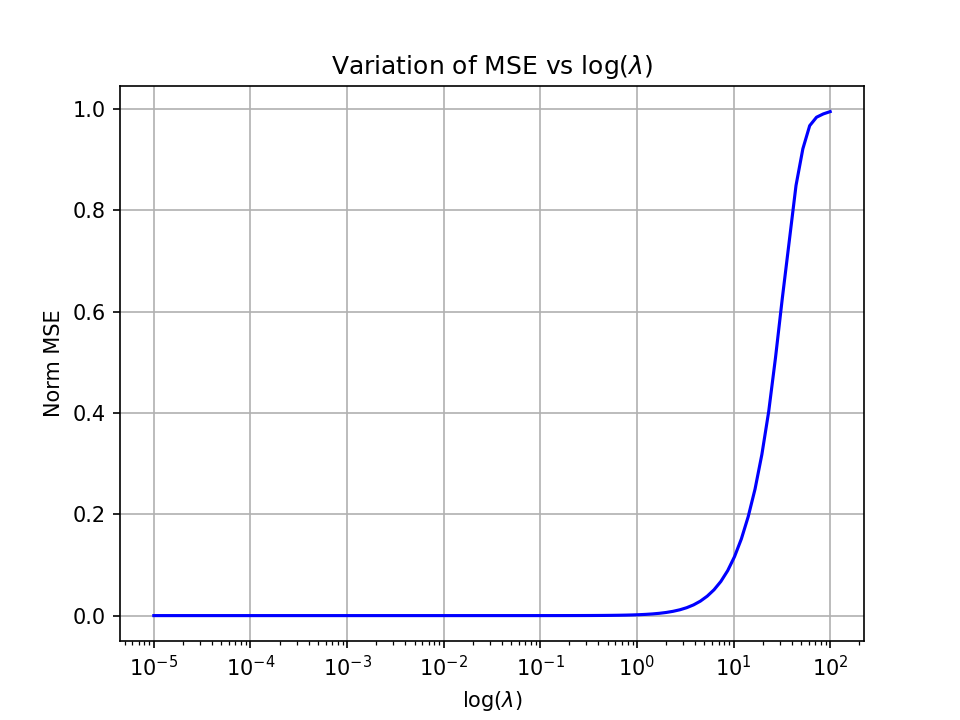

In [17]:
plt.figure()
    
plt.plot(lambda_arr, norm_MSE_mat,color='b')
plt.xlabel('log($\lambda$)')
plt.ylabel('Norm MSE')
plt.xscale('log')
plt.title('Variation of MSE vs log($\lambda$)')
plt.grid()
plt.savefig('./plots/5a_22.eps',dpi=300)

<IPython.core.display.Javascript object>


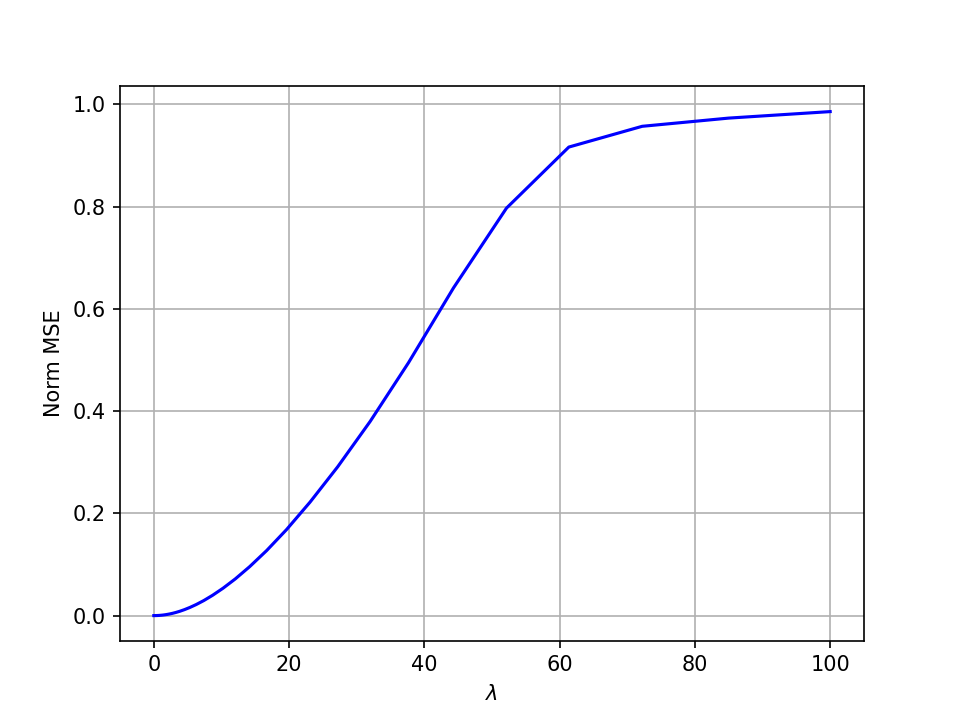

In [18]:
# Plot of normalized MSE versus lambda averaging over data drawn from each component

# Storing indexes of three components
comp_1_idx = []
comp_2_idx = []
comp_3_idx = []
for i in range(total_data_num):
    if np.array_equal(z_mat[:,i].reshape(3),np.array([1,0,0])):
        comp_1_idx.append(i)
    elif np.array_equal(z_mat[:,i].reshape(3),np.array([0,1,0])):
        comp_2_idx.append(i)
    elif np.array_equal(z_mat[:,i].reshape(3),np.array([0,0,1])):
        comp_3_idx.append(i)
        
curr_component = comp_1_idx
num_draws = len(curr_component)
B = u_mat # Basis for the signal B = [u1 u2 u3 u4 u5 u6]  dx6
Phi_cap = Phi @ B
#lambda_arr = np.array([0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,5])
lambda_arr = np.logspace(-5,2,num=100)
norm_MSE_mat = np.zeros(lambda_arr.size)
comp_num = 1

for j in range(len(lambda_arr)):
    norm_MSE = 0
    for i in curr_component:
        x = x_mat[:,i].reshape(100,1)
        xs = xs_mat[:,i].reshape(100,1)
        z = z_mat[:,i].reshape(3,1)

        # Computation of compressive projection
        p = 1/math.sqrt(m) * (Phi@x)
        p1 = Phi @ x #scikit-learn uses p without 1/sqrt(m) factor 
        clf = linear_model.Lasso(alpha=lambda_arr[j])
        clf.fit(Phi_cap,p1)

        s = clf.coef_.reshape(6,1)
        xs_cap = B @ s
        loss_norm = np.linalg.norm(xs_cap-xs)
        sparse_signal_norm = np.linalg.norm(xs)
        norm_MSE = norm_MSE + (loss_norm**2)/(sparse_signal_norm**2)
    norm_MSE_mat[j] = norm_MSE/num_draws

plt.figure()
plt.plot(lambda_arr, norm_MSE_mat,color='b')
plt.xlabel('$\lambda$')
plt.ylabel('Norm MSE')
plt.title('Variation of MSE vs $\lambda$ (Component {})'.format(comp_num))
plt.grid()
#plt.savefig('./plots/5b_11.eps',dpi=300)

<IPython.core.display.Javascript object>


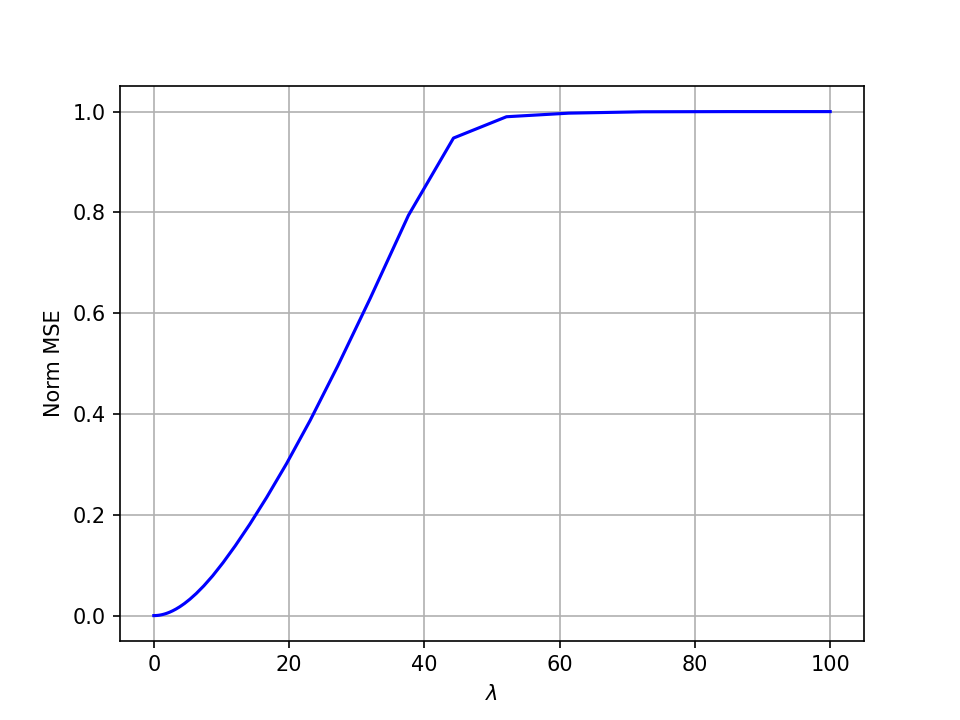

In [19]:
curr_component = comp_2_idx
num_draws = len(curr_component)
B = u_mat # Basis for the signal B = [u1 u2 u3 u4 u5 u6]  dx6
Phi_cap = Phi @ B
#lambda_arr = np.array([0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,5])
lambda_arr = np.logspace(-5,2,num=100)
norm_MSE_mat = np.zeros(lambda_arr.size)
comp_num = 2

for j in range(len(lambda_arr)):
    norm_MSE = 0
    for i in curr_component:
        x = x_mat[:,i].reshape(100,1)
        xs = xs_mat[:,i].reshape(100,1)
        z = z_mat[:,i].reshape(3,1)

        # Computation of compressive projection
        p = 1/math.sqrt(m) * (Phi@x)
        p1 = Phi @ x #scikit-learn uses p without 1/sqrt(m) factor 
        clf = linear_model.Lasso(alpha=lambda_arr[j])
        clf.fit(Phi_cap,p1)

        s = clf.coef_.reshape(6,1)
        xs_cap = B @ s
        loss_norm = np.linalg.norm(xs_cap-xs)
        sparse_signal_norm = np.linalg.norm(xs)
        norm_MSE = norm_MSE + (loss_norm**2)/(sparse_signal_norm**2)
    norm_MSE_mat[j] = norm_MSE/num_draws

plt.figure()
plt.plot(lambda_arr, norm_MSE_mat,color='b')
plt.xlabel('$\lambda$')
plt.ylabel('Norm MSE')
plt.title('Variation of MSE vs $\lambda$ (Component {})'.format(comp_num))
#plt.savefig('./plots/5b_22.eps',dpi=300)

<IPython.core.display.Javascript object>


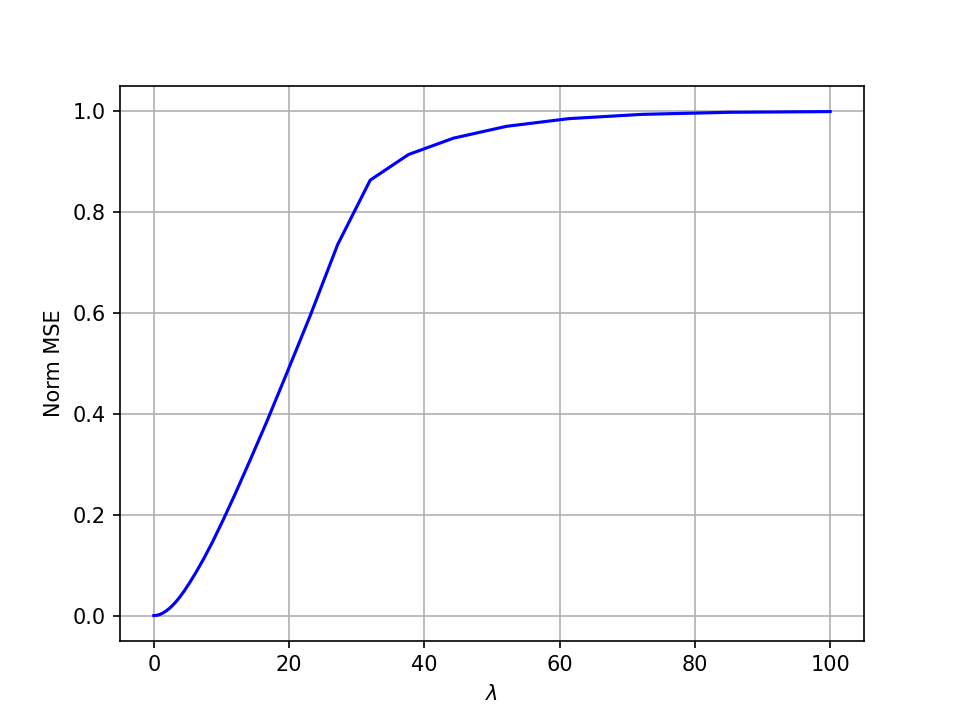

In [21]:
curr_component = comp_3_idx
num_draws = len(curr_component)
B = u_mat # Basis for the signal B = [u1 u2 u3 u4 u5 u6]  dx6
Phi_cap = Phi @ B
#lambda_arr = np.array([0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,5])
lambda_arr = np.logspace(-5,2,num=100)
norm_MSE_mat = np.zeros(lambda_arr.size)
comp_num = 3

for j in range(len(lambda_arr)):
    norm_MSE = 0
    for i in curr_component:
        x = x_mat[:,i].reshape(100,1)
        xs = xs_mat[:,i].reshape(100,1)
        z = z_mat[:,i].reshape(3,1)

        # Computation of compressive projection
        p = 1/math.sqrt(m) * (Phi@x)
        p1 = Phi @ x #scikit-learn uses p without 1/sqrt(m) factor 
        clf = linear_model.Lasso(alpha=lambda_arr[j])
        clf.fit(Phi_cap,p1)

        s = clf.coef_.reshape(6,1)
        xs_cap = B @ s
        loss_norm = np.linalg.norm(xs_cap-xs)
        sparse_signal_norm = np.linalg.norm(xs)
        norm_MSE = norm_MSE + (loss_norm**2)/(sparse_signal_norm**2)
    norm_MSE_mat[j] = norm_MSE/num_draws

plt.figure()
plt.plot(lambda_arr, norm_MSE_mat,color='b')
plt.xlabel('$\lambda$')
plt.ylabel('Norm MSE')
plt.title('Variation of MSE vs $\lambda$ (Component {})'.format(comp_num))
plt.grid()
#plt.savefig('./plots/5b_33.eps',dpi=300)